# Image Classification - CSV 5-Class Pipeline

This notebook trains a five-class classifier directly from a `combined.csv` file, which merges training and validation data. The CSV contains an `id`, `file_name`, and `label` for images in the `combined/` folder. Inference is performed on the `test.csv` and `test/` data.

Key features of this pipeline:
- Creates a stratified train/validation split (92/8) from the combined dataset.
- Optimizes for multi-class classification using cross-entropy loss, tracking accuracy and macro F1-score.
- The data augmentation pipeline is simple, consisting of resizing and normalization. More advanced augmentations are available but commented out.

## 1) Setup

In [ ]:
# %pip install -U timm scikit-learn bitsandbytes torchvision torch --extra-index-url https://download.pytorch.org/whl/cu118

## 2) Imports & Utilities

In [1]:
import os, math, time, random, warnings
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import timm
from timm.data import resolve_model_data_config
from timm.scheduler import CosineLRScheduler

# Import for 8-bit optimizer for memory savings
try:
    import bitsandbytes as bnb
    USE_BNB = True
except ImportError:
    USE_BNB = False
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 3) Configuration

In [ ]:
# ========= Config =========
@dataclass
class CFG:
    # --- Paths
    data_root: str = '.'
    train_csv: str = 'combined.csv'
    test_csv: str = 'test.csv'
    train_dir: str = 'combined'
    test_dir: str = 'test'
    out_dir: str = 'runs/convnextv2'

    # --- Split
    val_split: float = 0.08
    seed: int = 42

    # --- Imbalance handling
    use_class_weights: bool = True

    # --- Model
    # model_name: str = 'vit_base_patch16_siglip_224.v2_webli'
    model_name: str = 'convnextv2_tiny.fcmae_ft_in22k_in1k'
    drop_path: float = 0.08
    freeze_blocks: int = 0  # 0 = full fine-tuning, 1 = freeze all but head

    # --- Optimization
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1e-6
    peak_lr: float = 2e-4
    grad_checkpointing: bool = True
    accum_steps: int = 1  # Gradient accumulation steps

    # --- Dataloader
    workers: int = 0

    # --- Task
    num_classes: int = 5

CFG = CFG()
Path(CFG.out_dir).mkdir(parents=True, exist_ok=True)


## 4) Dataset & Transforms

In [3]:
# ========= Dataset & Transforms =========

class CsvImageDataset(Dataset):
    def __init__(self, root, csv_file, img_dir, transform=None, with_labels=True, dataframe=None):
        self.root = Path(root)
        if dataframe is not None:
            self.df = dataframe.reset_index(drop=True).copy()
            self.source_name = csv_file or 'provided dataframe'
        else:
            if csv_file is None:
                raise ValueError("csv_file must be provided when dataframe is None")
            self.df = pd.read_csv(self.root / csv_file)
            self.source_name = csv_file
        self.img_dir = self.root / img_dir
        self.transform = transform
        self.with_labels = with_labels

        required_cols = ['file_name']
        if with_labels:
            required_cols.append('label')
        for col in required_cols:
            if col not in self.df.columns:
                raise ValueError(f"Missing column '{col}' in {self.source_name}")

        self.file_names = self.df['file_name'].tolist()
        self.ids = self.df['id'].tolist() if 'id' in self.df.columns else self.file_names
        self.targets = self.df['label'].astype('int64').tolist() if with_labels else None

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img = Image.open(self.img_dir / self.file_names[idx]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if self.with_labels:
            return img, self.targets[idx]
        return img, {'id': self.ids[idx], 'file_name': self.file_names[idx]}

# ========= Model-specific transforms =========
_tmp = timm.create_model(CFG.model_name, pretrained=True, num_classes=0)
data_config = resolve_model_data_config(_tmp)
del _tmp

IMG_SIZE = tuple(data_config['input_size'][1:]) or (data_config['input_size'][1],)
if len(IMG_SIZE) == 1:
    IMG_SIZE = (IMG_SIZE[0], IMG_SIZE[0])

#### OVERRIDE IMG_SIZE to 128x256
# IMG_SIZE = (128, 256)
# IMG_SIZE = (120, 230)

NORM_MEAN = data_config['mean']
NORM_STD = data_config['std']

train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomApply([
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
    # ], p=0.5),
    # transforms.RandomApply([
    #     transforms.RandomPerspective(distortion_scale=0.2)
    # ], p=0.3),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # rotate
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees=15)
    # ], p=0.7),
    # transforms.RandomGrayscale(p=0.1),
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
    # transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    # transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
])

# ========= Build datasets / loaders =========
LABEL_IDS = list(range(CFG.num_classes))
full_df = pd.read_csv(Path(CFG.data_root) / CFG.train_csv)
class_counts = full_df['label'].value_counts().reindex(LABEL_IDS, fill_value=0)
if (class_counts == 0).any():
    missing = [cls for cls, cnt in class_counts.items() if cnt == 0]
    warnings.warn(f"No samples found for classes: {missing}. F1 will be zero for them.")
balanced_counts = class_counts.clip(lower=1)
CLASS_WEIGHTS = torch.tensor(
    (len(full_df) / (CFG.num_classes * balanced_counts)).astype('float32').values,
    dtype=torch.float32,
)
print("Class distribution (full dataset):", class_counts.to_dict())

train_df, val_df = train_test_split(
    full_df,
    test_size=CFG.val_split,
    stratify=full_df['label'],
    random_state=CFG.seed,
    shuffle=True,
)

train_ds = CsvImageDataset(CFG.data_root, CFG.train_csv, CFG.train_dir,
                           transform=train_transform, with_labels=True, dataframe=train_df)
val_ds = CsvImageDataset(CFG.data_root, CFG.train_csv, CFG.train_dir,
                         transform=val_transform, with_labels=True, dataframe=val_df)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.workers, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=max(1, CFG.batch_size), shuffle=False,
                        num_workers=CFG.workers, pin_memory=True)

print(f"Split {len(full_df)} samples -> Train {len(train_ds)} | Val {len(val_ds)} | Classes: {CFG.num_classes}")


Class distribution (full dataset): {0: 15865, 1: 8601, 2: 12277, 3: 8838, 4: 10737}
Split 56318 samples -> Train 51812 | Val 4506 | Classes: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Image batch shape: torch.Size([64, 3, 224, 224]) | Labels batch shape: torch.Size([64])


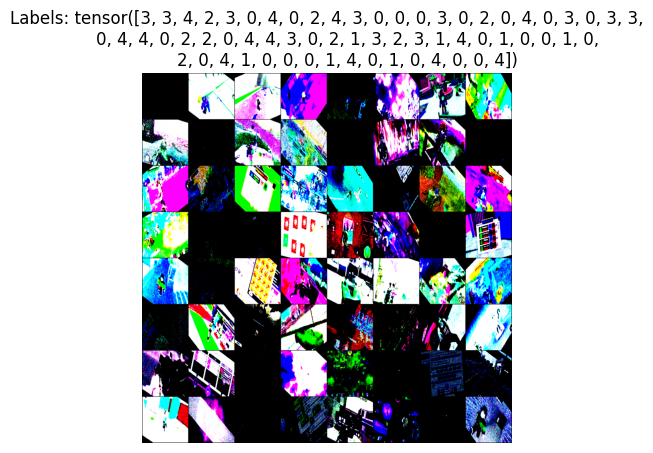

In [ ]:
# sample a batch
import matplotlib.pyplot as plt
import torchvision
for imgs, labels in train_loader:
    print(f"Image batch shape: {imgs.shape} | Labels batch shape: {labels.shape}")
    # visualize a batch of images and their labels
    img_grid = torchvision.utils.make_grid(imgs, nrow=8)
    plt.imshow(img_grid.permute(1, 2, 0).cpu())
    plt.title(f"Labels: {labels}")
    plt.axis("off")
    plt.show()
    break

## 5) Model, Optimizer & Loss

In [5]:
# ========= Model =========
def create_model(num_classes=CFG.num_classes):
    model = timm.create_model(
        CFG.model_name,
        pretrained=True,
        num_classes=num_classes,
        drop_path_rate=CFG.drop_path,
        # img_size=IMG_SIZE,
    )
    if CFG.freeze_blocks > 0:
        for idx, (_, module) in enumerate(model.named_children()):
            if idx < CFG.freeze_blocks:
                for param in module.parameters():
                    param.requires_grad = False
    if CFG.grad_checkpointing and hasattr(model, 'set_grad_checkpointing'):
        model.set_grad_checkpointing(True)
    return model

model = create_model().to(device)
print(f"Model: {CFG.model_name}")
print("Total params (M):", sum(p.numel() for p in model.parameters())/1e6)
print("Trainable params (M):", sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6)

if USE_BNB:
    optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=CFG.peak_lr)
    print("Using 8-bit AdamW optimizer.")
else:
    optimizer = optim.AdamW(model.parameters(), lr=CFG.peak_lr)

scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
steps_per_epoch = math.ceil(len(train_loader) / CFG.accum_steps)
total_updates = max(1, CFG.epochs * steps_per_epoch)
warmup_updates = max(1, steps_per_epoch)
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=total_updates,
    lr_min=CFG.lr,
    warmup_lr_init=CFG.lr,
    warmup_t=warmup_updates,
    warmup_prefix=False,
    t_in_epochs=False,
)
loss_weights = CLASS_WEIGHTS.to(device) if CFG.use_class_weights else None
if CFG.use_class_weights:
    print(f"Using class weights: {loss_weights.tolist()}")
criterion = nn.CrossEntropyLoss(weight=loss_weights).to(device)


Model: convnextv2_tiny.fcmae_ft_in22k_in1k
Total params (M): 27.870341
Trainable params (M): 27.870341
Using 8-bit AdamW optimizer.
Using class weights: [0.7099653482437134, 1.3095686435699463, 0.9174553751945496, 1.2744512557983398, 1.0490453243255615]


## 6) Metrics & Evaluation

In [6]:
# ========= Metrics =========
@torch.no_grad()
def evaluate(eval_model, loader):
    eval_model.eval()
    total_loss, n_samples = 0.0, 0
    all_preds, all_targets = [], []
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            logits = eval_model(images)
            loss = criterion(logits, targets)

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        bs = images.size(0)
        total_loss += loss.item() * bs
        n_samples += bs
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    acc = float((all_preds == all_targets).mean())
    macro_f1 = f1_score(all_targets, all_preds, average='macro', labels=LABEL_IDS, zero_division=0)
    per_class_f1 = f1_score(all_targets, all_preds, average=None, labels=LABEL_IDS, zero_division=0)
    per_class_f1 = {label: float(score) for label, score in zip(LABEL_IDS, per_class_f1)}
    avg_loss = total_loss / max(1, n_samples)
    return avg_loss, acc, macro_f1, per_class_f1

def format_f1(per_class_dict):
    return ' | '.join([f"{cls}:{score:.3f}" for cls, score in per_class_dict.items()])


## 7) Training Loop

In [7]:
# ========= Train =========
best_f1, best_epoch = -1.0, -1
start_time = time.time()
global_update = 0

for epoch in range(CFG.epochs):
    model.train()
    running_loss, seen = 0.0, 0
    train_preds, train_targets = [], []
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{CFG.epochs}")
    optimizer.zero_grad(set_to_none=True)

    for step, (images, targets) in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(images)
            loss = criterion(logits, targets)
            loss_to_backprop = loss / CFG.accum_steps

        scaler.scale(loss_to_backprop).backward()

        if ((step + 1) % CFG.accum_steps) == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            global_update += 1
            scheduler.step_update(global_update)

        running_loss += loss.item() * images.size(0)
        seen += images.size(0)
        train_preds.append(torch.argmax(logits.detach(), dim=1).cpu().numpy())
        train_targets.append(targets.detach().cpu().numpy())
        current_lr = optimizer.param_groups[0]["lr"]
        pbar.set_postfix(loss=running_loss / max(1, seen), lr=current_lr)

    train_preds = np.concatenate(train_preds, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)
    train_acc = float((train_preds == train_targets).mean())
    train_f1 = f1_score(train_targets, train_preds, average='macro', labels=LABEL_IDS, zero_division=0)
    train_f1_per_class = f1_score(train_targets, train_preds, average=None, labels=LABEL_IDS, zero_division=0)
    train_f1_per_class = {label: float(score) for label, score in zip(LABEL_IDS, train_f1_per_class)}

    val_loss, val_acc, val_f1, val_f1_per_class = evaluate(model, val_loader)
    improved = val_f1 > best_f1
    if improved:
        best_f1, best_epoch = val_f1, epoch
        torch.save({'model': model.state_dict(), 'macro_f1': best_f1}, Path(CFG.out_dir) / 'best.pth')

    print(
        f"Epoch {epoch+1}: train_loss={running_loss/max(1,seen):.4f} | val_loss={val_loss:.4f} | "
        f"train_acc={train_acc:.4f} | val_acc={val_acc:.4f} | "
        f"train_macroF1={train_f1:.4f} | val_macroF1={val_f1:.4f} | best_macroF1={best_f1:.4f} (ep {best_epoch+1})"
    )
    print(f"    Train per-class F1: {format_f1(train_f1_per_class)}")
    print(f"    Val per-class F1:   {format_f1(val_f1_per_class)}")

end_time = time.time()
print(f"Training finished in {(end_time - start_time)/60:.2f} minutes.")
print(f"Best macro F1: {best_f1:.4f} at epoch {best_epoch+1}")


Epoch 1/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4397 | val_loss=0.1571 | train_acc=0.8395 | val_acc=0.9439 | train_macroF1=0.8326 | val_macroF1=0.9415 | best_macroF1=0.9415 (ep 1)
    Train per-class F1: 0:0.892 | 1:0.838 | 2:0.819 | 3:0.765 | 4:0.848
    Val per-class F1:   0:0.956 | 1:0.934 | 2:0.951 | 3:0.926 | 4:0.941


Epoch 2/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 2: train_loss=0.1260 | val_loss=0.0927 | train_acc=0.9590 | val_acc=0.9716 | train_macroF1=0.9570 | val_macroF1=0.9704 | best_macroF1=0.9704 (ep 2)
    Train per-class F1: 0:0.972 | 1:0.954 | 2:0.958 | 3:0.943 | 4:0.958
    Val per-class F1:   0:0.978 | 1:0.965 | 2:0.973 | 3:0.964 | 4:0.972


Epoch 3/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0638 | val_loss=0.0870 | train_acc=0.9783 | val_acc=0.9729 | train_macroF1=0.9776 | val_macroF1=0.9718 | best_macroF1=0.9718 (ep 3)
    Train per-class F1: 0:0.984 | 1:0.978 | 2:0.978 | 3:0.973 | 4:0.976
    Val per-class F1:   0:0.982 | 1:0.971 | 2:0.972 | 3:0.966 | 4:0.968


Epoch 4/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 4: train_loss=0.0405 | val_loss=0.0824 | train_acc=0.9862 | val_acc=0.9751 | train_macroF1=0.9858 | val_macroF1=0.9741 | best_macroF1=0.9741 (ep 4)
    Train per-class F1: 0:0.989 | 1:0.985 | 2:0.986 | 3:0.985 | 4:0.984
    Val per-class F1:   0:0.981 | 1:0.978 | 2:0.979 | 3:0.957 | 4:0.975


Epoch 5/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0265 | val_loss=0.0582 | train_acc=0.9910 | val_acc=0.9836 | train_macroF1=0.9907 | val_macroF1=0.9836 | best_macroF1=0.9836 (ep 5)
    Train per-class F1: 0:0.993 | 1:0.990 | 2:0.991 | 3:0.989 | 4:0.990
    Val per-class F1:   0:0.981 | 1:0.982 | 2:0.989 | 3:0.984 | 4:0.982


Epoch 6/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0122 | val_loss=0.0646 | train_acc=0.9959 | val_acc=0.9822 | train_macroF1=0.9959 | val_macroF1=0.9813 | best_macroF1=0.9836 (ep 5)
    Train per-class F1: 0:0.996 | 1:0.996 | 2:0.996 | 3:0.996 | 4:0.995
    Val per-class F1:   0:0.985 | 1:0.974 | 2:0.989 | 3:0.978 | 4:0.980


Epoch 7/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0072 | val_loss=0.0612 | train_acc=0.9977 | val_acc=0.9842 | train_macroF1=0.9977 | val_macroF1=0.9831 | best_macroF1=0.9836 (ep 5)
    Train per-class F1: 0:0.998 | 1:0.998 | 2:0.998 | 3:0.998 | 4:0.996
    Val per-class F1:   0:0.988 | 1:0.978 | 2:0.992 | 3:0.978 | 4:0.980


Epoch 8/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0037 | val_loss=0.0453 | train_acc=0.9990 | val_acc=0.9885 | train_macroF1=0.9990 | val_macroF1=0.9880 | best_macroF1=0.9880 (ep 8)
    Train per-class F1: 0:0.999 | 1:0.999 | 2:0.999 | 3:0.999 | 4:0.999
    Val per-class F1:   0:0.990 | 1:0.985 | 2:0.992 | 3:0.987 | 4:0.985


Epoch 9/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0019 | val_loss=0.0449 | train_acc=0.9995 | val_acc=0.9887 | train_macroF1=0.9995 | val_macroF1=0.9881 | best_macroF1=0.9881 (ep 9)
    Train per-class F1: 0:0.999 | 1:1.000 | 2:1.000 | 3:1.000 | 4:0.999
    Val per-class F1:   0:0.991 | 1:0.983 | 2:0.993 | 3:0.989 | 4:0.985


Epoch 10/10:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 10: train_loss=0.0016 | val_loss=0.0429 | train_acc=0.9995 | val_acc=0.9891 | train_macroF1=0.9995 | val_macroF1=0.9887 | best_macroF1=0.9887 (ep 10)
    Train per-class F1: 0:0.999 | 1:0.999 | 2:1.000 | 3:1.000 | 4:0.999
    Val per-class F1:   0:0.991 | 1:0.984 | 2:0.994 | 3:0.990 | 4:0.985
Training finished in 120.39 minutes.
Best macro F1: 0.9887 at epoch 10


## 8) Inference & Submission

In [8]:
# ========= Inference helper =========
@torch.no_grad()
def predict_test_to_csv():
    """Loads the best model and generates a submission.csv file for the test set."""
    test_ds = CsvImageDataset(CFG.data_root, CFG.test_csv, CFG.test_dir, transform=val_transform, with_labels=False)
    test_loader = DataLoader(test_ds, batch_size=max(1, CFG.batch_size), shuffle=False,
                             num_workers=CFG.workers, pin_memory=True)

    # mdl = create_model().to(device)
    # ckpt_path = Path(CFG.out_dir) / 'best.pth'

    # if ckpt_path.exists():
    #     state = torch.load(ckpt_path, map_location=device)
    #     mdl.load_state_dict(state['model'])
    #     print(f"Loaded best checkpoint from: {ckpt_path}")
    # else:
    #     mdl.load_state_dict(model.state_dict())
    #     print("No best.pth found, using in-memory model.")
    
    mdl = model

    mdl.eval()
    all_ids, all_files, all_preds, all_probs = [], [], [], []
    for images, meta in tqdm(test_loader, desc="Predicting"):
        images = images.to(device, non_blocking=True)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            logits = mdl(images)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        preds = probs.argmax(axis=1)

        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_ids.extend(meta['id'])
        all_files.extend(meta['file_name'])

    prob_matrix = np.concatenate(all_probs, axis=0)
    sub_df = pd.DataFrame({
        'id': all_ids,
        'file_name': all_files,
        'label': all_preds,
    })
    for cls_idx in range(prob_matrix.shape[1]):
        sub_df[f'prob_{cls_idx}'] = prob_matrix[:, cls_idx]

    save_path = Path(CFG.out_dir) / 'submission.csv'
    sub_df.to_csv(save_path, index=False)
    print(f"Saved predictions to: {save_path}")
    print(sub_df.head())

# Run inference after training is complete
predict_test_to_csv()


Predicting:   0%|          | 0/405 [00:00<?, ?it/s]

Saved predictions to: runs\convnextv2\submission.csv
         id    file_name  label        prob_0        prob_1    prob_2  \
0  ANS00001  scyd5lz.jpg      1  6.735325e-06  9.956055e-01  0.003670   
1  ANS00002  slbh6z4.jpg      4  3.375244e-02  3.213501e-02  0.000588   
2  ANS00003  s3u8t8d.jpg      3  1.788139e-07  1.037121e-05  0.000007   
3  ANS00004  s0jrf0c.jpg      2  6.556511e-06  3.039837e-06  0.991211   
4  ANS00005  susbkwa.jpg      3  1.788139e-07  2.980232e-07  0.000004   

     prob_3        prob_4  
0  0.000027  6.217957e-04  
1  0.002522  9.311523e-01  
2  1.000000  7.158518e-05  
3  0.008987  1.192093e-07  
4  1.000000  5.364418e-06  
